In [69]:
import ticktack                 # For the compilation of the model
import ode                      # As a method of solving the odes
import numpy as np              # For the basic functions that need to be written
from jax import numpy as jnp    # annoying shit that I wish I didn't hav to deal with 
import jax.experimental.ode as jax  # Jax odeint 
import pandas as pd             # Becuase I want to 
from time import process_time   # For timing the different ode implementations

In [5]:
parameters = np.zeros(6)            # Empty array to hold the parameters of the prodcution function 
parameters[0] = 7.044873503263437   # Mean of the sinusoidal production 
parameters[1] = 0.18                # Amplitude of the sinusoidal production 
parameters[2] = 11.0                # Period of the sinusoidal production 
parameters[3] = 1.25                # Phase of the sinusoidal production 
parameters[4] = 120.05769867244142  # Height of the super-gaussian 
parameters[5] = 12.0                # Width of the super-gaussian 

In [6]:
projection = np.zeros(11)   # An array to hold the projection of the production function 
projection[0] = 0.7         # Proportion projection into the stratosphere       
projection[1] = 0.3         # Proportion projection into the troposphere

In [7]:
def production(t):    
    """
    The production function defined as the sum of sinusoidal and super-gaussian terms 
    """
    return parameters[0] * (1 + parameters[1] * \
        jnp.sin(2 * jnp.pi / parameters[2] * t + parameters[3])) + \
        parameters[4] * jnp.exp(- (parameters[5] * (t - 775)) ** 16)

In [8]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()   # Constructing the transfer operator 

In [9]:
u0 = np.array([135.76261605786132, 709.7591911307035,
    1191.489526709938, 3.97158546945107, 45158.65854589925,
    155.54703228960028, 634.290736403387, 423.5954241095565,
    1808.3343542055652, 665.933052175064, 7348.751626918585])

In [10]:
def dydx(y, t):
    """
    The gradient of the carbon box model.
    """
    return cbm._matrix @ y + production(t) * projection

This is going very very well. I need to go plumbing again though. this means that I can look through the depths of the ode implementation and destroy the extra return improving my ability to do things

In [136]:
odes = {ode: np.NaN, jax: np.NaN}  # For the storage of the profiles 

for namespace in odes:      # Iterating through the namespaces that provide the odeint function 
    time_sample = np.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()  # starting a timer 
        C14 = namespace.odeint(dydx, u0, np.arange(760.0, 790.0, 1))    # runner the model 
        timer = process_time() - timer  # Stopping the timer 
        time_sample[i] = timer          # Storing the timer #! Can be shortened 

        if i == 9: # Storing the data from just the final run 
            #? So this is dogy as all hell. I need to implement this so that it can be put into a pandas data frame. That way I will be closer to weilding the might of scipy 
            odes[namespace] = {
                "time": np.NaN,             
                "time_variance": np.NaN,
                "accuracy": np.NaN,
                "accuracy_variance": np.NaN
            } 
            
            accuracy = C14[:, 2] 
            accuracy = (accuracy - np.median(accuracy)) / np.median(accuracy)
            accuracy_variance = np.var(accuracy)        
            time = np.mean(time_sample)
            time_variance = np.var(time_sample)

            #* This is very novice code

            odes[namespace]["time"] = time
            odes[namespace]["time_variance"] = time_variance
            odes[namespace]["accuracy"] = accuracy
            odes[namespace]["accuracy_variance"] = accuracy_variance




TypeError: tuple indices must be integers or slices, not tuple

It might be worth creating a time variable since I am constructing the same thing 3 times

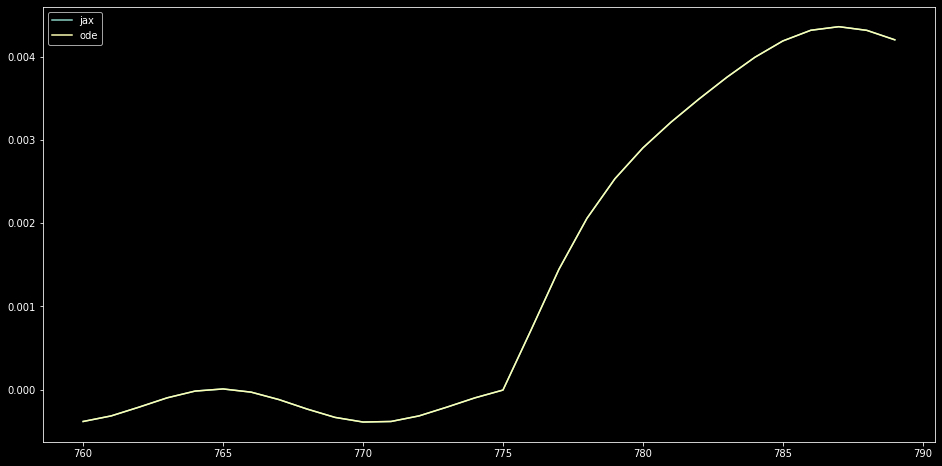

In [135]:
import matplotlib.pyplot as plt # Plotting library for visualisations
plt.style.use("dark_background")

time_space = np.arange(760.0, 790.0)    # times of the sampling 

jax_solution = jax.odeint(dydx, u0, np.arange(760.0, 790.0))[:, 2]
ode_solution = ode.odeint(dydx, u0, np.arange(760.0, 790.0))[0][:, 2]

#! I'm not sure that this is the best way to go about it
# jax_solution = (jax_solution - np.median(jax_solution)) / jax_solution
# ode_solution = (ode_solution - np.median(ode_solution)) / ode_solution

plt.plot(time_space, jax_solution, label="jax") # Plotting the entire data 
plt.plot(time_space, ode_solution, label="ode")
plt.legend()
plt.show()                      # Showing the plot 